In [1]:
import numpy as np
import joblib

from sklearn.metrics import roc_curve, auc

from matplotlib import pyplot as plt
import seaborn as sns
import glob
import os

In [2]:
def average(all_x, all_y):
    ux = np.unique(np.concatenate(all_x))
    uy = np.zeros_like(ux)
    n = len(all_x)
    for x, y in zip(all_x, all_y):
        a = np.interp(ux, x, y)
        uy += a
    uy /= n
    return ux, uy

In [3]:
magnification_factor = '0X'

In [4]:
# Parameters
magnification_factor = "400X"


In [5]:
self_path = os.getcwd()
os.chdir('../../Probas')

In [6]:
paths = glob.glob('*_' + magnification_factor + '_*probas.joblib')
paths

['vgginnet-ft_400X_5_probas.joblib',
 'vgginnet-ft_400X_4_probas.joblib',
 'vgginnet-ft_400X_2_probas.joblib',
 'vgginnet-ft_400X_3_probas.joblib',
 'vgginnet_400X_3_probas.joblib',
 'vgginnet-ft_400X_1_probas.joblib',
 'resnet_400X_probas.joblib',
 'vgginnet_400X_5_probas.joblib',
 'vgg_400X_probas.joblib',
 'inception_400X_probas.joblib',
 'vgginnet_400X_2_probas.joblib',
 'vgginnet_400X_1_probas.joblib',
 'vgginnet_400X_4_probas.joblib']

In [7]:
def clean(name):
    name = name.replace('vgginnet', 'VGGIN-Net')
    name = name.replace('vgg', 'VGG16')
    name = name.replace('inception', 'GoogLeNet')
    name = name.replace('resnet', 'ResNet50')
    name = name.replace('-ft', '_with Fine Tuning')
    name = name.replace('_', ' ')

    name = name.replace(" " + magnification_factor + " ", " ")
    
    name = name.replace(' probas.joblib', '')
    return name

In [8]:
probas = {clean(path): joblib.load(path)['y_probas'] for path in paths}
list(probas.keys())

['VGGIN-Net with Fine Tuning 5',
 'VGGIN-Net with Fine Tuning 4',
 'VGGIN-Net with Fine Tuning 2',
 'VGGIN-Net with Fine Tuning 3',
 'VGGIN-Net 3',
 'VGGIN-Net with Fine Tuning 1',
 'ResNet50',
 'VGGIN-Net 5',
 'VGG16',
 'GoogLeNet',
 'VGGIN-Net 2',
 'VGGIN-Net 1',
 'VGGIN-Net 4']

In [9]:
labels = {clean(path): joblib.load(path)['y_test'] for path in paths}
labels = {key: np.argmax(labels[key], axis=-1) for key in labels}
list(labels.keys())

['VGGIN-Net with Fine Tuning 5',
 'VGGIN-Net with Fine Tuning 4',
 'VGGIN-Net with Fine Tuning 2',
 'VGGIN-Net with Fine Tuning 3',
 'VGGIN-Net 3',
 'VGGIN-Net with Fine Tuning 1',
 'ResNet50',
 'VGGIN-Net 5',
 'VGG16',
 'GoogLeNet',
 'VGGIN-Net 2',
 'VGGIN-Net 1',
 'VGGIN-Net 4']

In [10]:
n_classes = 2
def process(y_test, y_probas):
    y_test_oh = np.eye(n_classes)[np.int32(y_test)]
    fpr, tpr = [], []
    
    for index in range(n_classes):
        fp, tp, _ = roc_curve(y_test_oh[:, index], y_probas[:, index])
        fpr.append(fp)
        tpr.append(tp)

    f, t = average(fpr, tpr)
    return f, t

In [11]:
sns.set()
sns.set_style('whitegrid')

In [12]:
rocs = {key: process(labels[key], probas[key]) for key in probas.keys()}
rocs

{'VGGIN-Net with Fine Tuning 5': (array([0.        , 0.01176471, 0.01470588, 0.02058824, 0.02647059,
         0.02941176, 0.03235294, 0.03529412, 0.03823529, 0.04117647,
         0.04705882, 0.05588235, 0.07352941, 0.07432432, 0.07941176,
         0.08783784, 0.09459459, 0.09705882, 0.10882353, 0.11486486,
         0.12162162, 0.12837838, 0.13513514, 0.13529412, 0.14864865,
         0.17058824, 0.17647059, 0.18529412, 0.19411765, 0.19594595,
         0.21621622, 0.23648649, 0.27352941, 0.33108108, 0.41764706,
         0.60810811, 1.        ]),
  array([0.        , 0.47651586, 0.51878672, 0.56278789, 0.60341068,
         0.62541127, 0.64741186, 0.6761692 , 0.69816979, 0.716792  ,
         0.75403641, 0.81665979, 0.93177142, 0.93827504, 0.94165342,
         0.95047695, 0.95194754, 0.95532591, 0.95870429, 0.96017488,
         0.96164547, 0.96311606, 0.96605723, 0.96943561, 0.97237679,
         0.97237679, 0.97237679, 0.97575517, 0.98251192, 0.9854531 ,
         0.98692369, 0.98839428, 0.9

In [13]:
single_fold = [
    'VGG16',
    'GoogLeNet',
    'ResNet50']

multi_fold = [
    'VGGIN-Net',
    'VGGIN-Net with Fine Tuning']

order = single_fold + multi_fold

In [14]:
curves = {}

for ord in multi_fold:
    fs, ts = [], []
    auc_vals = []
    for i in range(1, 5 + 1):
        name = ord + ' %d' % i
        f, t = rocs[name]
        
        auc_vals.append(auc(f, t))
        fs.append(f)
        ts.append(t)

    curves[ord] = {
        'curve': average(fs, ts),
        'auc_mean': np.mean(auc_vals),
        'auc_std': np.std(auc_vals)
    }

for ord in single_fold:
    f, t = rocs[ord]
    curves[ord] = {
        'curve': (f, t),
        'auc': auc(f, t)
    }

In [15]:
curves

{'VGGIN-Net': {'curve': (array([0.        , 0.01764706, 0.02058824, 0.02352941, 0.02647059,
          0.02941176, 0.03235294, 0.03529412, 0.03823529, 0.04117647,
          0.04411765, 0.04705882, 0.0472973 , 0.05      , 0.05294118,
          0.05405405, 0.05588235, 0.05882353, 0.06176471, 0.06470588,
          0.06756757, 0.06764706, 0.07058824, 0.07432432, 0.07647059,
          0.07941176, 0.08108108, 0.08235294, 0.08529412, 0.08783784,
          0.08823529, 0.09117647, 0.09411765, 0.09459459, 0.09705882,
          0.1       , 0.10135135, 0.10810811, 0.10882353, 0.11470588,
          0.11486486, 0.11764706, 0.12162162, 0.12352941, 0.12647059,
          0.12837838, 0.13235294, 0.13513514, 0.13529412, 0.13823529,
          0.14117647, 0.14189189, 0.14411765, 0.14705882, 0.14864865,
          0.15      , 0.15294118, 0.15540541, 0.15588235, 0.15882353,
          0.16216216, 0.16470588, 0.16764706, 0.16891892, 0.18243243,
          0.18918919, 0.19594595, 0.2027027 , 0.20945946, 0.21470588

In [16]:
os.chdir(self_path)
os.getcwd()

'/home/manisha.saini/vggin-net-github/utils/ROC'

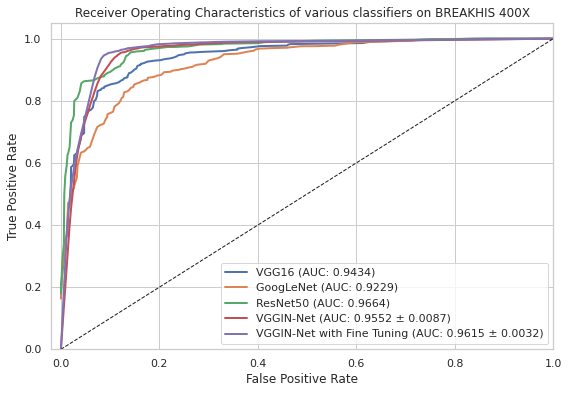

In [17]:
plt.figure(figsize=(9, 6))

lines = []
legends = []

for key in order:
    f, t = curves[key]['curve']
    line, = plt.plot(f, t, lw=2.)
    lines.append(line)

    if 'auc' in curves[key]:
        legends.append('%s (AUC: %0.4f)' % (key, curves[key]['auc']))
    else:
        legends.append('%s (AUC: %0.4f ± %0.4f)' % (key,
                                                    curves[key]['auc_mean'],
                                                    curves[key]['auc_std']))
    
plt.plot([0, 1], [0, 1], 'k--', lw=1)
plt.xlim([-0.02, 1.0])
plt.ylim([0.0, 1.05])

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

plt.legend(lines, legends)
plt.title('Receiver Operating Characteristics of various classifiers on BREAKHIS ' + magnification_factor)
plt.savefig('ROC' + magnification_factor + '.pdf')
plt.show()